# Model Testing
- Author: Daniel Zurawski, Keshav Kapoor
- Organization: Fermilab
- Grammar: Python 3.6.1

In [1]:
!nvidia-smi

Fri Aug 18 13:42:11 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |    925MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   29C    P8     9W / 180W |   7831MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker3d import loader, utils, metrics

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:04:00.0)


## Loading in Data

In [3]:
%%time
histories    = []
modelpath    = "models/KESHAV-UNIF-25T-1000E-PRZ-10N.h5"
order        = ("phi", "r", "z")
code         = (order[0][0] + order[1][0] + order[2][0]).upper()
n_noise      = 10
num_classes  = (25 + 2)
input_shape  = ((25 * 9) + n_noise, 3)
train_data, train_target = loader.from_file("datasets/npz/UNIF-25T-1000E-PRZ-10N.npz")
test_data,  test_target  = loader.from_file("datasets/npz/RAMP-PRZ-10N.npz")
print("train_data: {0}, train_target: {1}".format(train_data.shape, train_target.shape))
print("test_data: {0}, test_target: {1}".format(test_data.shape, test_target.shape))

train_data: (25000, 235, 3), train_target: (25000, 235, 27)
test_data: (3600, 235, 3), test_target: (3600, 235, 27)
CPU times: user 5.55 s, sys: 452 ms, total: 6 s
Wall time: 6.13 s


## Display an Example of the Data

In [4]:
e = 3435
print("Event Number {}".format(e))
utils.display_side_by_side(test_data[e], test_target[e], order=order)

Event Number 3435


,phi,r,z
0,-3.110905,271.0,86.296356
1,-3.109980,155.0,-5.971339
2,-3.101542,562.0,137.677734
3,-3.100270,85.0,-3.274606
4,-3.096081,39.0,-1.502466
5,-3.065297,405.0,-76.309685
6,-2.840262,562.0,-105.891472
7,-2.824978,85.0,13.218432
8,-2.823651,39.0,6.064928
9,-2.816595,155.0,24.104200


<IPython.core.display.Javascript object>


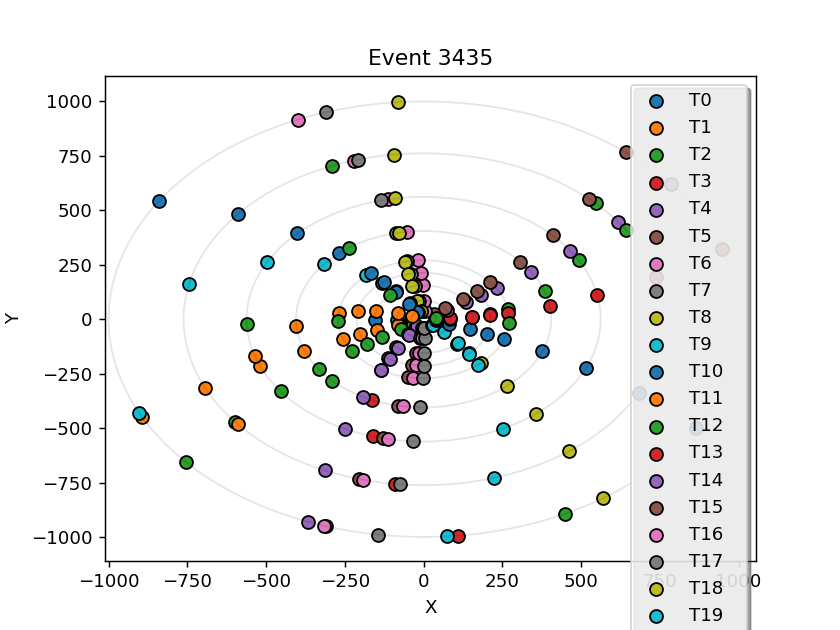

<IPython.core.display.Javascript object>


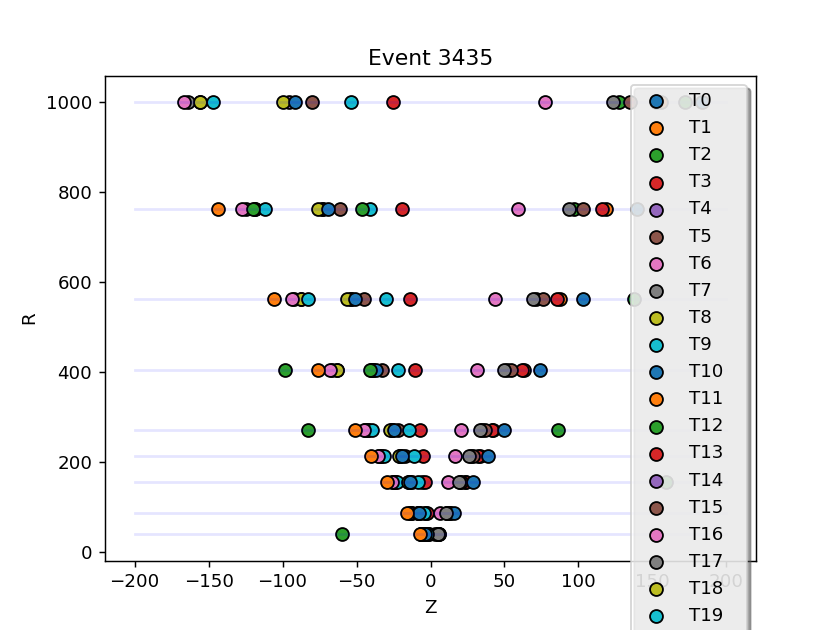

<IPython.core.display.Javascript object>


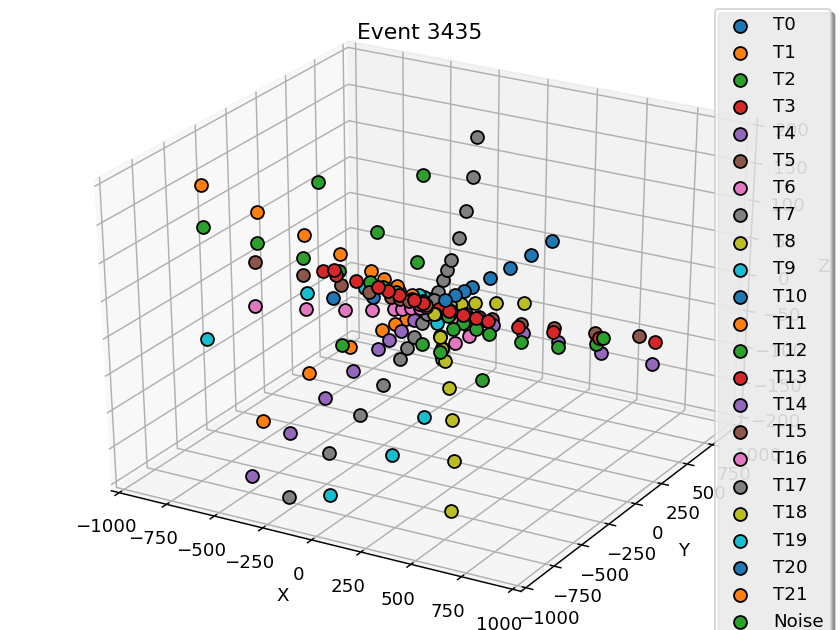

In [5]:
utils.plot3d(test_data[e], test_target[e], order=order, title="Event {}".format(e), flat_ax="z")
utils.plot3d(test_data[e], test_target[e], order=order, title="Event {}".format(e), flat_ax="r")
utils.plot3d(test_data[e], test_target[e], order=order, title="Event {}".format(e), flat_ax=None)

## Defining the Neural Network Model

In [6]:
# For reloading the model.
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(
        units=256,
        return_sequences=True,
        recurrent_dropout=0.4,
        implementation=2),
    input_shape=input_shape,
    merge_mode="mul"))
model.add(Dropout(0.4))
for _ in range(2):
    model.add(Bidirectional(
        GRU(
            units=256, 
            return_sequences=True, 
            recurrent_dropout=0.4, 
            implementation=2),
        merge_mode="mul"))
    model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
model.summary()

## Fitting the Neural Network Model

In [6]:
%%time
# So far, has been fitted on 60 epochs
epochs     = 32
batch_size = 32
histories.append(model.fit(
    train_data,
    train_target,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(test_data, test_target),
    callbacks=[keras.callbacks.ModelCheckpoint(
        filepath=modelpath,
        save_best_only=True,
        verbose=0
    )]
))

Train on 25000 samples, validate on 3600 samples
Epoch 1/32
25000/25000 [==============================] - 686s - loss: 0.3895 - acc: 0.8753 - val_loss: 0.1945 - val_acc: 0.9426
Epoch 2/32
25000/25000 [==============================] - 681s - loss: 0.3976 - acc: 0.8732 - val_loss: 0.1865 - val_acc: 0.9455
Epoch 3/32
25000/25000 [==============================] - 683s - loss: 0.3902 - acc: 0.8760 - val_loss: 0.1857 - val_acc: 0.9458
Epoch 4/32
25000/25000 [==============================] - 676s - loss: 0.3841 - acc: 0.8778 - val_loss: 0.1878 - val_acc: 0.9457
Epoch 5/32
25000/25000 [==============================] - 677s - loss: 0.3841 - acc: 0.8779 - val_loss: 0.1801 - val_acc: 0.9469
Epoch 6/32
25000/25000 [==============================] - 693s - loss: 0.3852 - acc: 0.8776 - val_loss: 0.1859 - val_acc: 0.9453
Epoch 7/32
25000/25000 [==============================] - 683s - loss: 0.3893 - acc: 0.8769 - val_loss: 0.1916 - val_acc: 0.9448
Epoch 8/32
25000/25000 [========================

## Plots of Predictions

In [ ]:
utils.graph_losses([("", i) for i in histories])
import pickle
with open('25T-HISTORY', 'wb') as f:
        pickle.dump([h.history for h in histories], f)

In [7]:
guesses = model.predict(test_data)
print("Discrete Accuracy: {}".format(metrics.discrete_accuracy_all(test_data, guesses, test_target)))

Discrete Accuracy: 0.8654338702478275


In [8]:
discrete_acc = metrics.discrete_accuracy(guesses[e], test_target[e])
print("Event {0}: Discrete Accuracy {1}".format(e, discrete_acc))
utils.display_side_by_side(test_data[e], guesses[e], test_target[e], order=order)

Event 3435: Discrete Accuracy 0.4973544973544973


,phi,r,z
0,-3.110905,271.0,86.296356
1,-3.109980,155.0,-5.971339
2,-3.101542,562.0,137.677734
3,-3.100270,85.0,-3.274606
4,-3.096081,39.0,-1.502466
5,-3.065297,405.0,-76.309685
6,-2.840262,562.0,-105.891472
7,-2.824978,85.0,13.218432
8,-2.823651,39.0,6.064928
9,-2.816595,155.0,24.104200


<IPython.core.display.Javascript object>


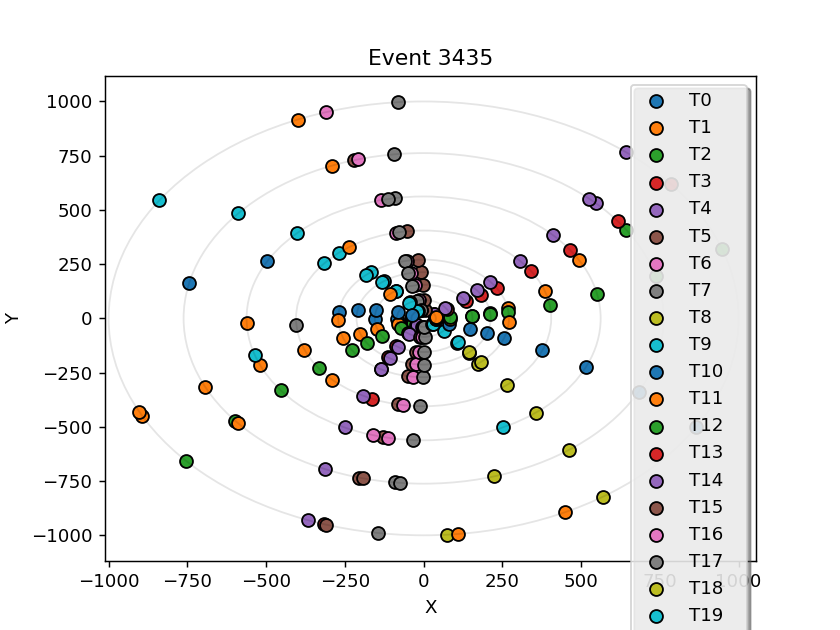

In [9]:
utils.plot3d(test_data[e], guesses[e], test_target[e], order=order, title="Event {}".format(e), flat_ax="z")
#utils.plot3d(test_data[e], guesses[e], test_target[e], order=order, title="Event {}".format(e), flat_ax="r")
#utils.plot3d(test_data[e], guesses[e], test_target[e], order=order, title="Event {}".format(e), flat_ax=None)

<IPython.core.display.Javascript object>


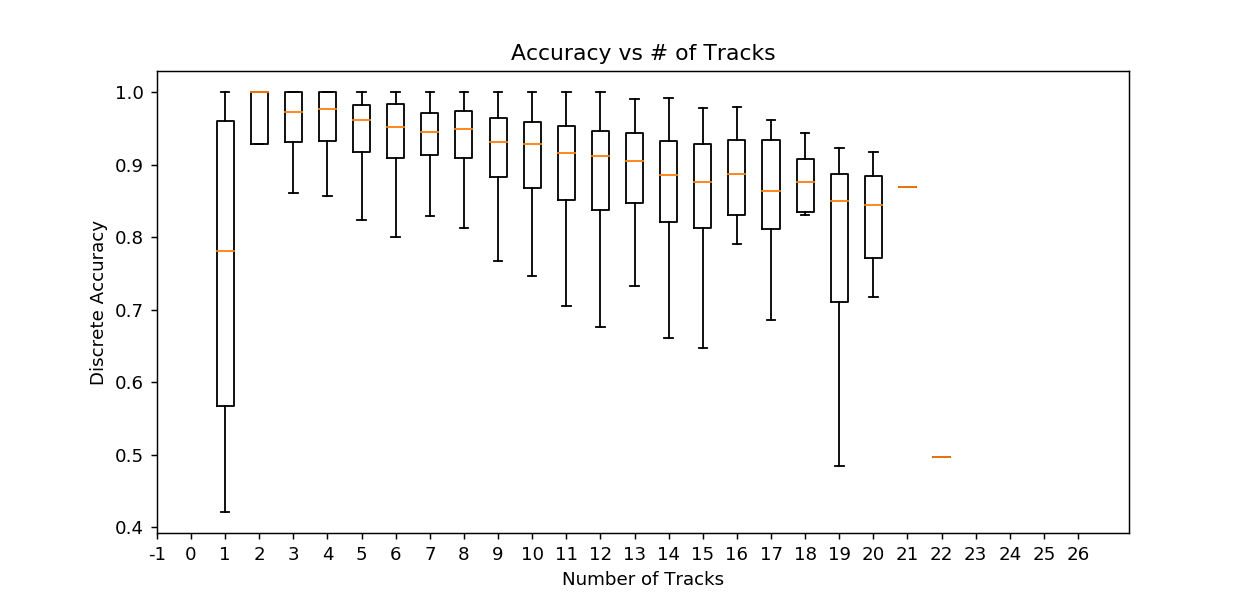

<IPython.core.display.Javascript object>


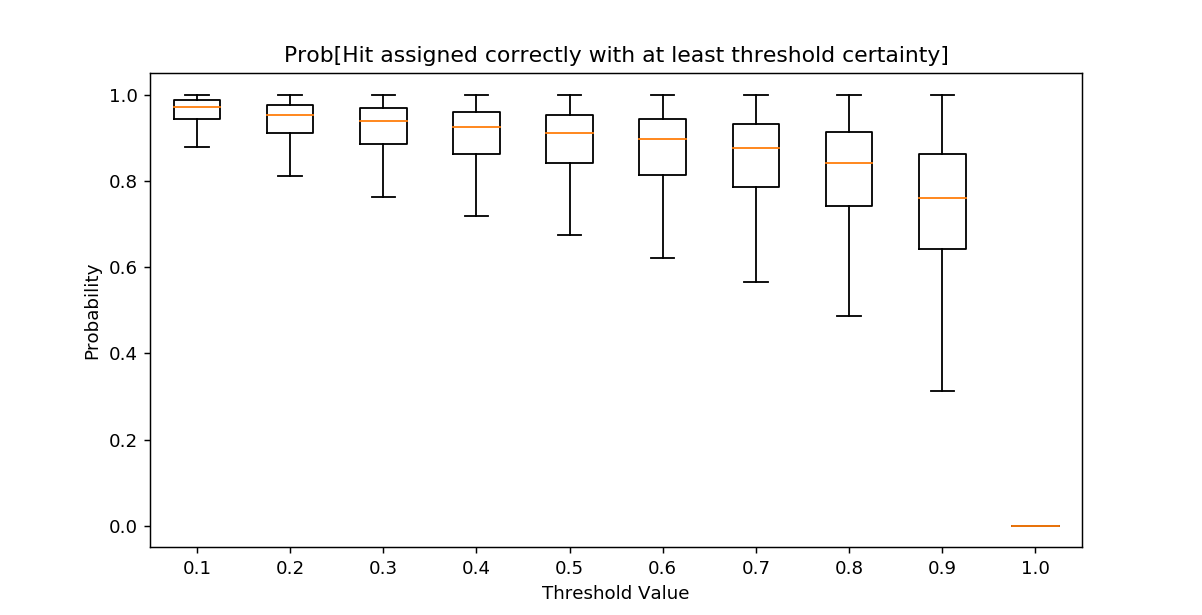

<IPython.core.display.Javascript object>


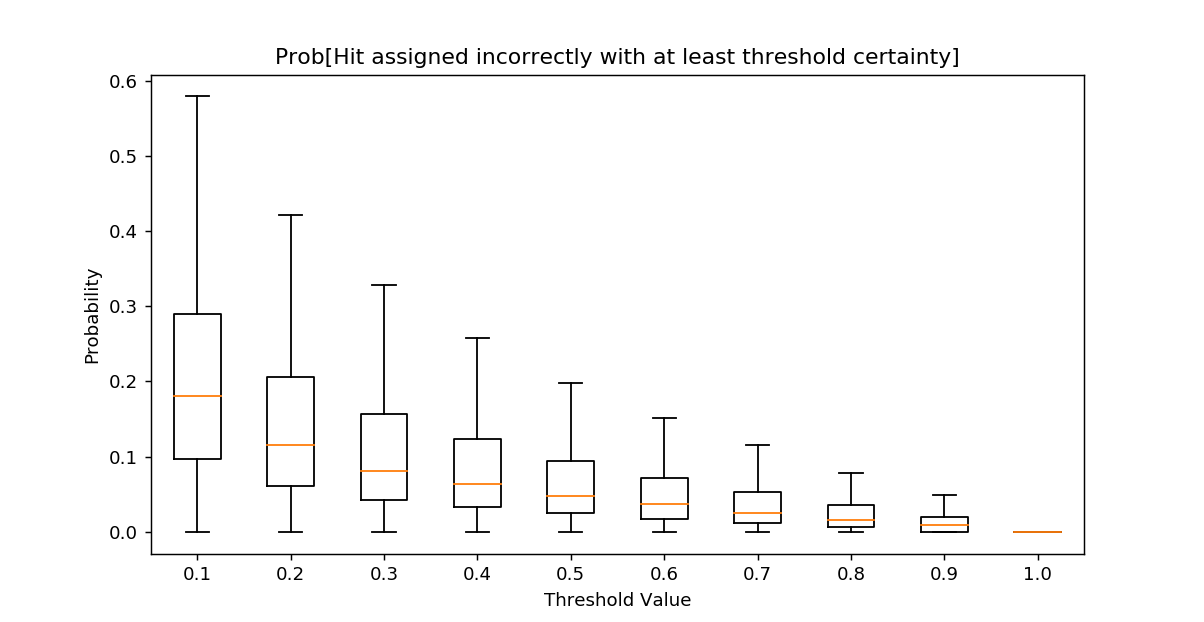

<IPython.core.display.Javascript object>


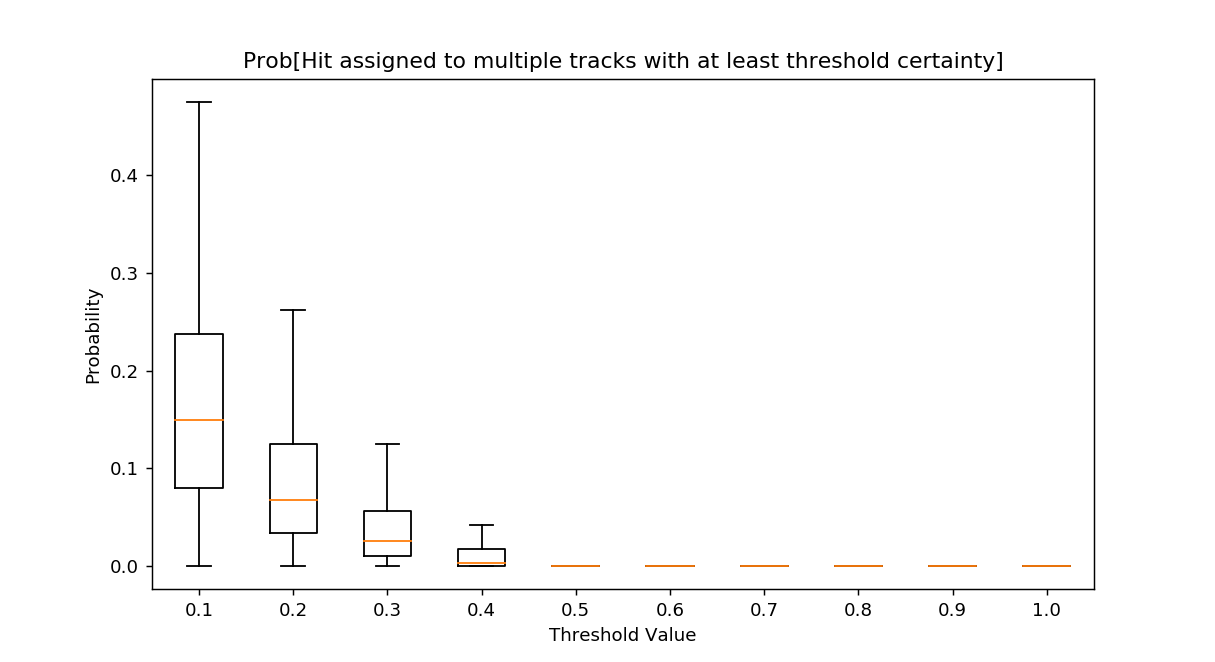

<IPython.core.display.Javascript object>


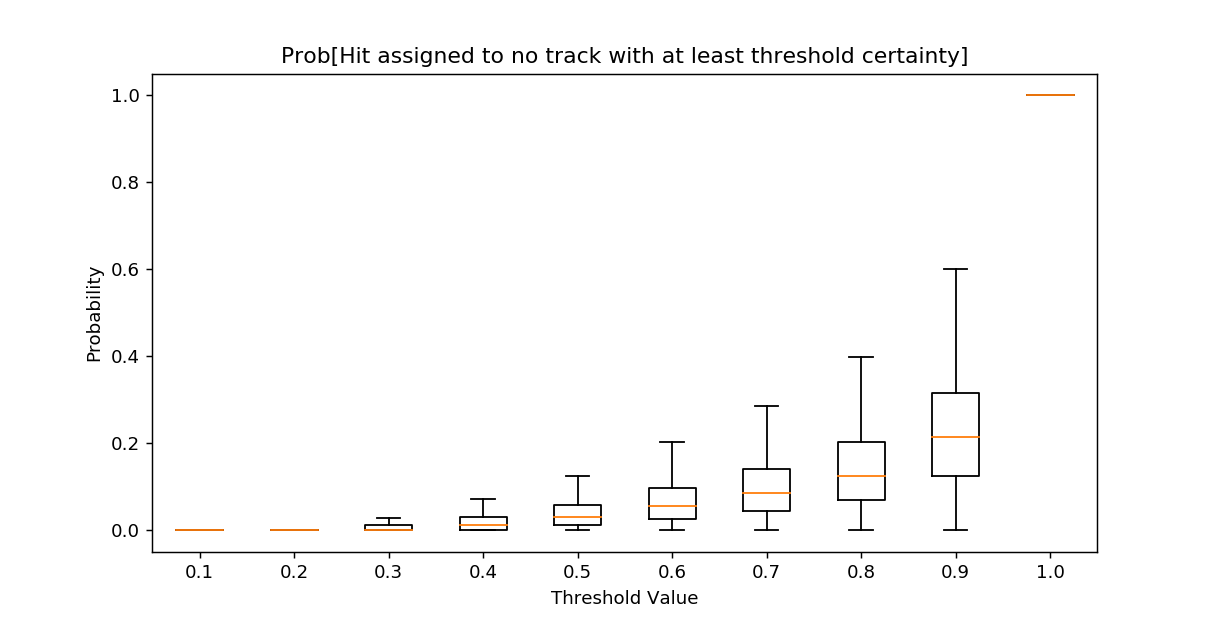

In [10]:
thresholds = [i / 10 for i in range(1, 1 + 10)]
_ = metrics.accuracy_vs_tracks_boxplot(guesses, test_target, noise=True)
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="correct")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="incorrect")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="many")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="none")